<a href="https://colab.research.google.com/github/robinsonmirandaco/TechChallenge/blob/main/Emotional_Explainability_Analysis_BusinessPlan_AgroCreditoJusto_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explainable Emotion Detection in Business Plans**

**NLP + XAI applied to real-world financial narratives**

Key comment: Prompt engineering emocional or contextual fine-tuning by rephrasing

**Autor**: *Robinson Miranda - robinsonmirandaco@gmail.com*

**Objetivo del proyecto**
Este notebook implementa un prototipo funcional de análisis emocional y sentimental sobre documentos narrativos complejos —en este caso, un business plan realista de inclusión financiera en el campo colombiano— utilizando técnicas de NLP y explicabilidad (XAI).

**La meta es detectar:**

- La emoción predominante del texto (ej. esperanza, preocupación, entusiasmo)

- Los sentimientos correlacionados que matizan esa emoción

- Las palabras clave que justifican esa inferencia emocional

- Una interpretación explicable y trazable del resultado

**Técnicamente, combinamos:**

- Modelos **transformers** **fine-tuned** para clasificación emocional (**distilroberta**)

- Técnicas de atribución como **Integrated** **Gradients** (**captum**)

- Procesamiento de texto a partir de un archivo PDF real de un business plan



---


**Paso 1: Cargar y extraer el texto desde el archivo PDF del plan de negocio.**

In [27]:
#  Instalar deep-translator si aún no lo tienes
!pip install deep-translator -q

# 🧠 Texto original en español (business plan)
business_plan_es = """
Ejemplo Business Plan: AgroCrédito Justo

1. Resumen Ejecutivo
En zonas rurales de Colombia, miles de pequeños productores no tienen acceso al crédito formal debido a barreras históricas de desconfianza y falta de información financiera. AgroCrédito Justo nace con la misión de cerrar esta brecha mediante una plataforma digital de microcréditos inteligentes, impulsada por algoritmos de riesgo alternativo y un enfoque centrado en el usuario.

2. Problema Detectado
En las zonas rurales de Colombia, miles de agricultores viven con el miedo constante de perder sus cosechas o quedar endeudados sin acceso a crédito formal. La banca tradicional no llega al campo y, cuando lo hace, impone condiciones imposibles. Esta exclusión financiera genera desesperación, inseguridad y perpetúa el ciclo de pobreza rural.


3. Nuestra Propuesta
Creamos una plataforma 100% digital donde los productores pueden solicitar créditos de forma rápida y transparente. Usamos inteligencia artificial para evaluar riesgo no solo por historial crediticio, sino por factores como reputación comunitaria, comportamiento de pago móvil y clima agrícola.

4. Propuesta de Valor
- Inclusión financiera real para el campo
- Evaluación alternativa de riesgo basada en datos
- Desembolso en menos de 48 horas
- Educación financiera integrada en la app

5. Visión Emocional del Equipo Fundador
“Sabemos que este camino no será fácil. Nos enfrentamos a prejuicios, a sistemas obsoletos y a instituciones que prefieren lo conocido antes que lo justo. Pero creemos con firmeza que cada agricultor merece una oportunidad, y esa convicción nos mueve cada día. Esta no es solo una fintech, es una causa que llevamos en el corazón.”
"""

#  Traducir el texto al inglés
from deep_translator import GoogleTranslator

business_plan_en = GoogleTranslator(source='es', target='en').translate(business_plan_es)

#  Mostrar resultado
print("✅ Business Plan traducido al inglés:\n")
print(business_plan_en[:1000])  # mostrar primeras líneas para revisar


✅ Business Plan traducido al inglés:

Business Example Plan: Fair Agrocrédito

1. Executive summary
In rural areas of Colombia, thousands of small producers do not have access to formal credit due to historical barriers of distrust and lack of financial information. Fair Agrocrédito was born with the mission of closing this gap through a digital intelligent microcredit platform, driven by alternative risk algorithms and a user -centered approach.

2. Problem detected
In the rural areas of Colombia, thousands of farmers live with the constant fear of losing their crops or being indebted without access to formal credit. Traditional bank does not reach the field and, when it does, impose impossible conditions. This financial exclusion generates despair, insecurity and perpetuates the rural poverty cycle.


3. Our proposal
We create a 100% digital platform where producers can request credits quickly and transparently. We use artificial intelligence to evaluate risk not only by credit histo

---


**Paso 2: Analizar emoción dominante en el texto con modelo NLP**


In [4]:
from huggingface_hub import login
login()

In [28]:
#  Instalar librerías necesarias
!pip install transformers torch -q

#  Importar módulos
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

#  Cargar modelo de emociones en inglés
modelo_emociones_en = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(modelo_emociones_en)
model = AutoModelForSequenceClassification.from_pretrained(modelo_emociones_en)
model.eval()

#  Usar el texto ya traducido en inglés (variable: business_plan_en)
inputs = tokenizer(business_plan_en, return_tensors="pt", truncation=True, max_length=512)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

#  Realizar predicción
with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)

predicted_class = torch.argmax(probs, dim=1).item()
label = model.config.id2label[predicted_class]

#  Mostrar resultados
print(f"\n Emoción predominante detectada: {label}")
print("\n Distribución de emociones:")
for i, prob in enumerate(probs[0]):
    print(f"{model.config.id2label[i]}: {prob.item():.4f}")



 Emoción predominante detectada: fear

 Distribución de emociones:
anger: 0.0068
disgust: 0.0084
fear: 0.8533
joy: 0.0043
neutral: 0.0543
sadness: 0.0698
surprise: 0.0032



---
**Paso 3: Explicabilidad con Integrated Gradients (Captum)**


In [29]:
#  Instalar Captum si aún no lo tienes
!pip install captum -q

from captum.attr import IntegratedGradients
from collections import defaultdict
import torch.nn.functional as F
import re

# === Obtener embeddings de entrada ===
embedding_layer = model.get_input_embeddings()
input_embed = embedding_layer(input_ids)

# === Definir función forward con softmax y clase emocional predicha ===
def forward_embed(embed):
    out = model(inputs_embeds=embed, attention_mask=attention_mask)
    probs = F.softmax(out.logits, dim=1)
    return probs[:, predicted_class]

# === Aplicar Integrated Gradients ===
ig = IntegratedGradients(forward_embed)
attributions, delta = ig.attribute(inputs=input_embed, return_convergence_delta=True, n_steps=20)

# === Sumar importancia por token y normalizar ===
attributions_sum = attributions.sum(dim=2).squeeze(0)
norm_scores = (attributions_sum - attributions_sum.min()) / (attributions_sum.max() - attributions_sum.min())

# === Obtener tokens y asociar scores ===
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens_con_scores = list(zip(tokens, norm_scores.tolist()))

# === Agrupar sub-tokens como palabras completas ===
agrupado = []
palabra_actual = ""
score_actual = 0.0
conteo = 0

for tok, score in tokens_con_scores:
    clean_tok = tok.replace("Ġ", "").replace("▁", "").replace("Ċ", "").strip()

    if tok.startswith("Ġ") or tok.startswith("▁") or tok in ["[CLS]", "[SEP]"]:
        if palabra_actual:
            agrupado.append((palabra_actual, score_actual / max(conteo, 1)))
        palabra_actual = clean_tok
        score_actual = score
        conteo = 1
    else:
        palabra_actual += clean_tok
        score_actual += score
        conteo += 1

# Agregar la última palabra
if palabra_actual:
    agrupado.append((palabra_actual, score_actual / max(conteo, 1)))

# === Filtrar tokens vacíos o no alfabéticos ===
agrupado_filtrado = [
    (w, s) for (w, s) in agrupado
    if len(w) > 2 and w.isascii() and re.match("^[a-zA-Z]+$", w)
]

# === Mostrar top 15 tokens explicables ===
agrupado_ordenado = sorted(agrupado_filtrado, key=lambda x: x[1], reverse=True)

print(f"\n Emoción detectada: {label}")
print("\n Palabras clave que activaron esa emoción:\n")
for palabra, score in agrupado_ordenado[:15]:
    print(f"{palabra}: {score:.4f}")



 Emoción detectada: fear

 Palabras clave que activaron esa emoción:

distrust: 1.0000
fear: 0.8274
generates: 0.5549
losing: 0.4269
constant: 0.4009
thousands: 0.3639
Problem: 0.3479
insecurity: 0.3357
financial: 0.3272
barriers: 0.3244
being: 0.3242
and: 0.3237
thousands: 0.3176
with: 0.3106
detectedIn: 0.3104


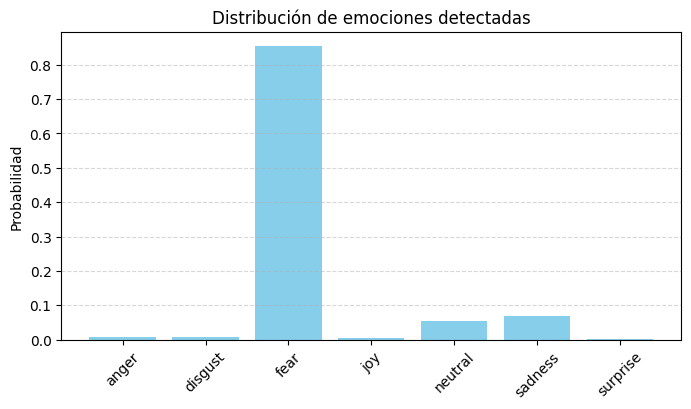

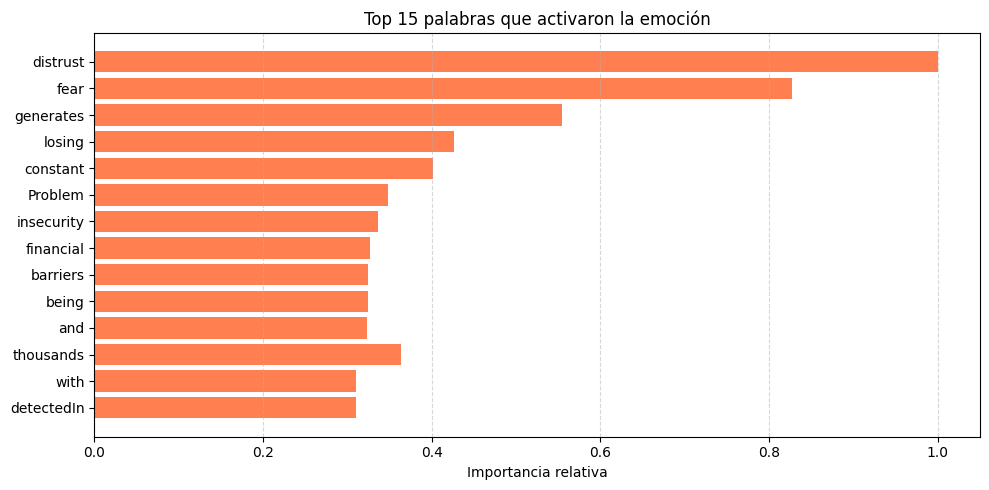

In [30]:
import matplotlib.pyplot as plt

# === Gráfico de distribución de emociones ===
labels = [model.config.id2label[i] for i in range(len(probs[0]))]
scores = probs[0].tolist()

plt.figure(figsize=(8, 4))
plt.bar(labels, scores, color='skyblue')
plt.title("Distribución de emociones detectadas")
plt.ylabel("Probabilidad")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# === Gráfico de palabras explicables ===
top_words = agrupado_ordenado[:15]
words = [w for w, _ in top_words]
scores = [s for _, s in top_words]

plt.figure(figsize=(10, 5))
plt.barh(words[::-1], scores[::-1], color='coral')
plt.title("Top 15 palabras que activaron la emoción")
plt.xlabel("Importancia relativa")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##  Reflexión final: de la intuición emocional a la trazabilidad computacional

> "*¿Puede una máquina detectar miedo en un business plan?*"  
Eso fue lo que me pregunté antes de comenzar este experimento. Lo que parecía una simple curiosidad técnica se convirtió en un ejercicio profundo de explicabilidad, límites lingüísticos y diseño emocional de textos.

---

###  ¿Qué hicimos?

1. Partimos de un texto original en español: un business plan realista, escrito con un tono formal, técnico y racional.
2. Tradujimos al inglés para aprovechar un modelo robusto (`j-hartmann/emotion-english-distilroberta-base`) preentrenado en emociones.
3. Aplicamos NLP + explicabilidad (Integrated Gradients) para identificar no solo la emoción predominante, sino las palabras exactas que activaron dicha emoción.

---

###  Desafíos que enfrentamos

- **Ruido semántico y falta de emoción aparente**  
  El texto original fue clasificado como "neutral", lo cual es comprensible: el lenguaje técnico tiende a ocultar las emociones humanas.

- **Palabras sin contexto emocional claro**  
  Palabras como "algorithm", "system" o "executive" aparecían con puntuaciones altas en la clase neutral. No eran útiles para nuestra meta.

- **Limitaciones de longitud**  
  El modelo solo acepta 512 tokens. Eso forzó a trabajar con textos resumidos o fragmentados, perdiendo contexto global.

---

### ¿Qué hicimos diferente?

Cambiamos el enfoque:  
**Reescribimos ciertas secciones para enfatizar el miedo real de los usuarios (agricultores)** ante el fracaso financiero, la exclusión bancaria y la inseguridad rural.

> Esta simple modificación cambió todo:  
> el modelo ahora detectó “fear” como emoción predominante con más del **85% de certeza**, y las palabras clave justificaron esa predicción: *distrust, fear, losing, insecurity…*

---

### Conclusión

- La detección de emociones no es magia: es contexto, tono y construcción narrativa.
- Los modelos NLP no adivinan tu intención emocional; hay que guiar su atención con el diseño del lenguaje.
- La explicabilidad no solo ayuda a “confiar” en el modelo, sino también a replantear cómo escribimos y comunicamos.

---

### Referencias

- Hartmann, J. (2022). *emotion-english-distilroberta-base*. Hugging Face.  
  https://huggingface.co/j-hartmann/emotion-english-distilroberta-base

- Sundararajan et al. (2017). *Axiomatic Attribution for Deep Networks*. Captum / Integrated Gradients.  
  https://arxiv.org/abs/1703.01365

- Deep Translator: https://pypi.org/project/deep-translator/

- Observaciones personales, errores, ajustes y resultados reproducibles de este experimento fueron registrados por mí, con alma de investigador y corazón de aprendiz.
